In [687]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import plot_tree
import scipy.stats as stats
from sklearn.cluster import KMeans


In [688]:
concrete = pd.read_csv('concrete.csv')
concrete.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [689]:
concrete.shape
#concrete.dtypes

(1030, 9)

In [690]:
concrete.isna().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [691]:
concrete.describe().transpose()
## This is not a classification problem. but rather a prediction of contninious values and not discrete values

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


ash is a rarely used? or is it a data miss?
slag also seems extremely skewed.
Super plastic and age also seems to have many outliers


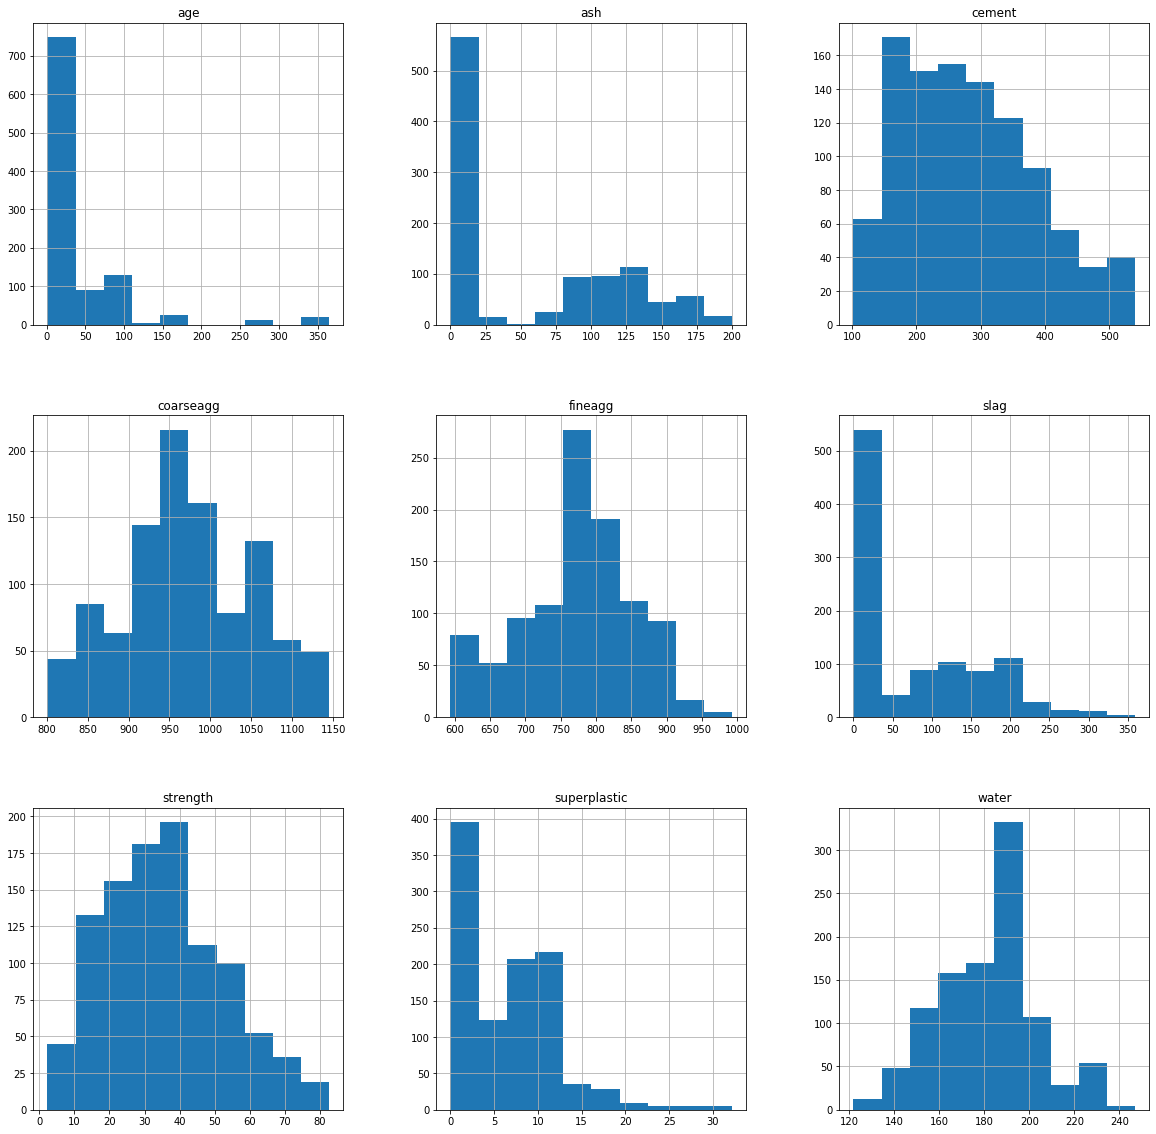

In [692]:
concrete.hist(figsize=(20,20))
plt.show()

# Age seems to have a lot of outliers. How do we treat it?
# possibly slag too


Age has many outliers. while other also have outliers but isnt as dispersed as Age. Superplastic can also be considered for removing outliers

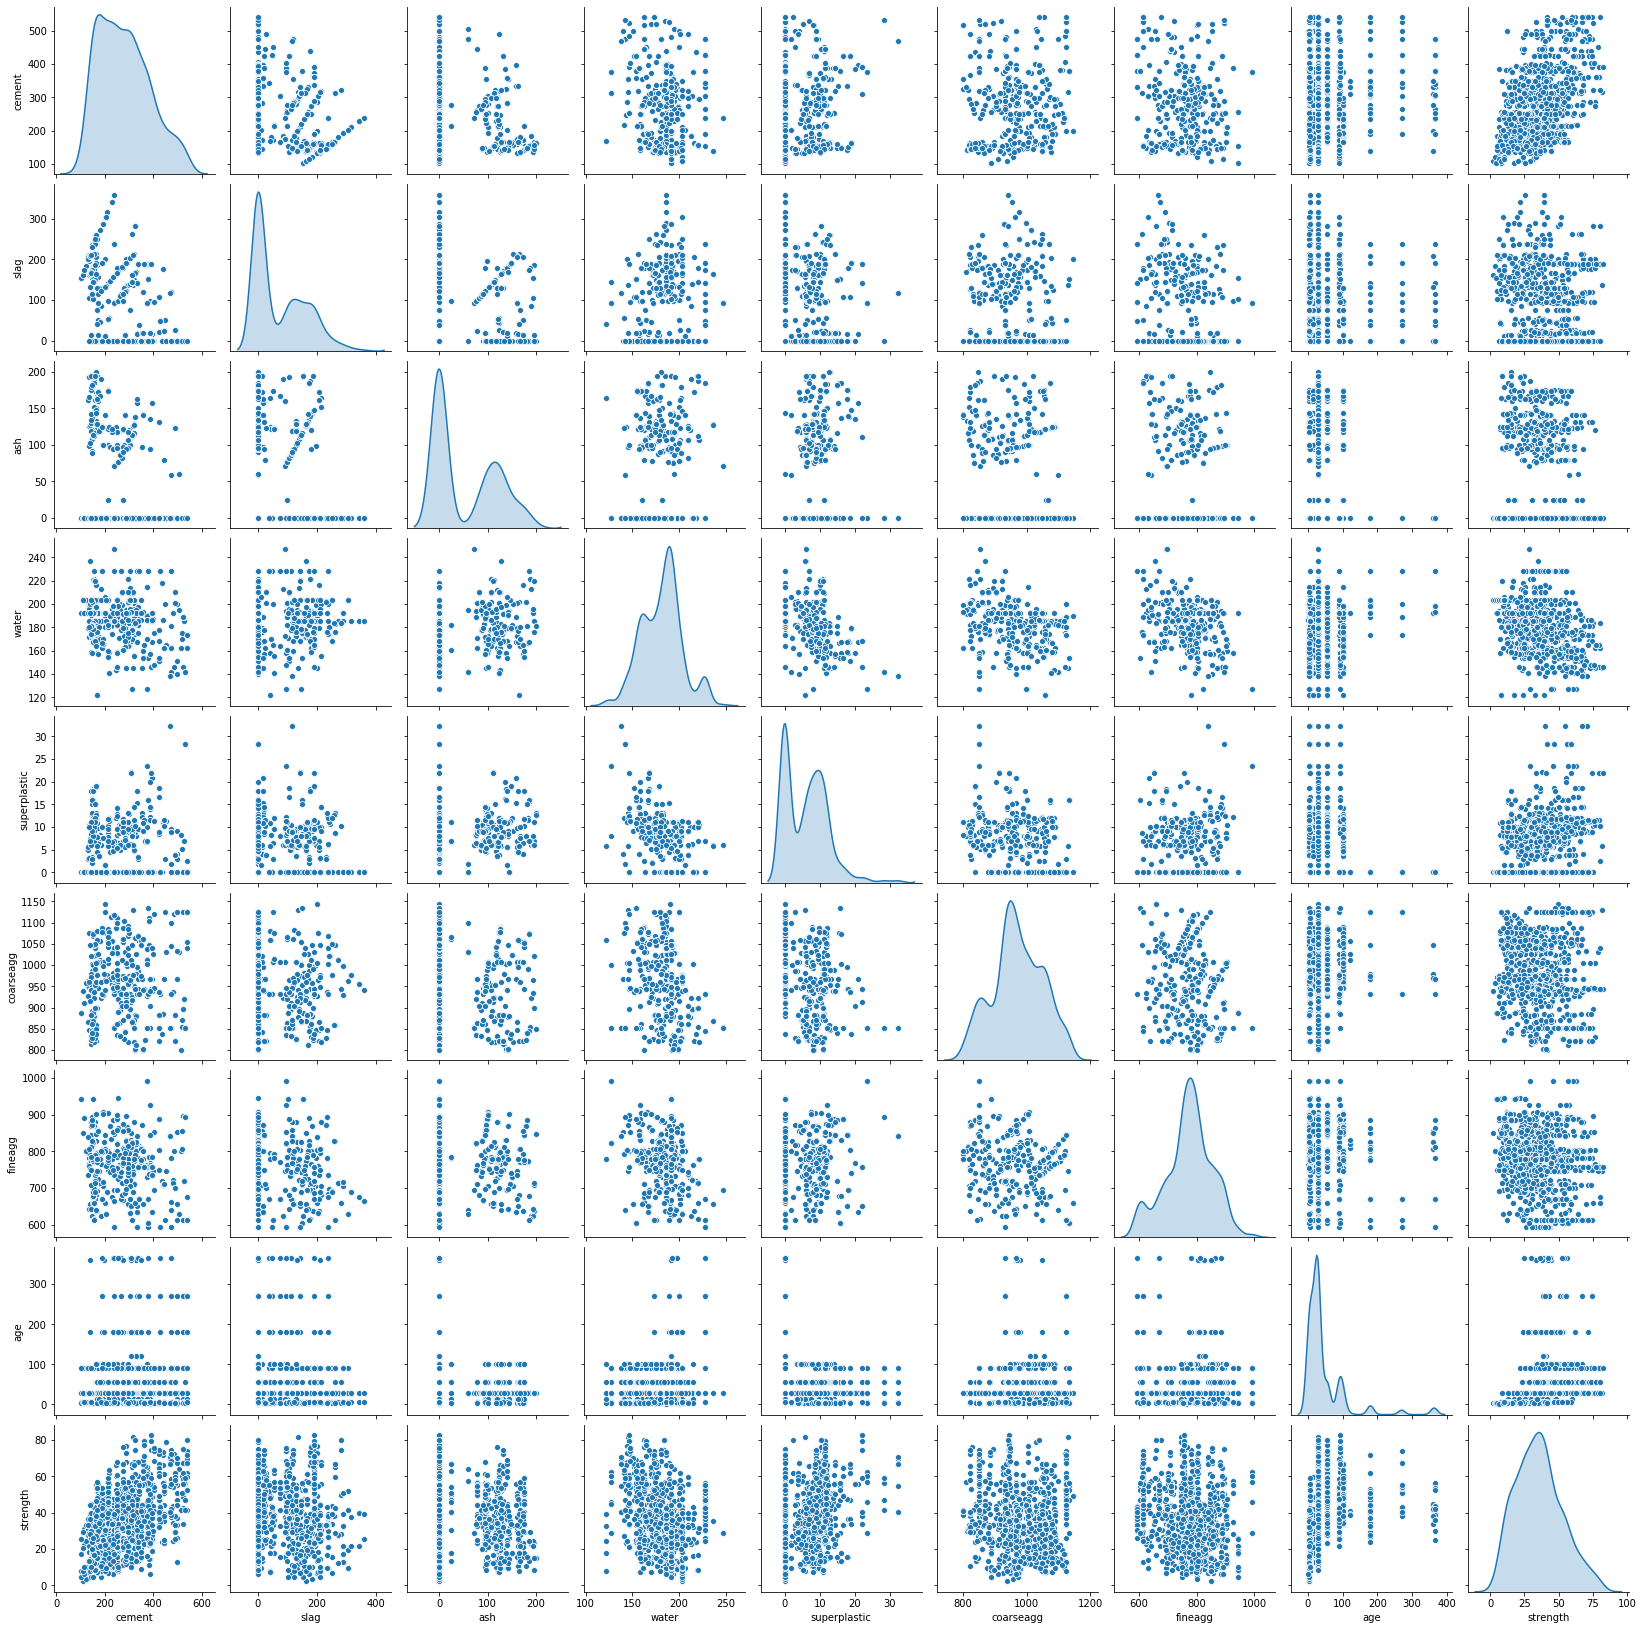

In [693]:
sns.pairplot(concrete, diag_kind="kde")

There seems to be no direct coorelation between strengh and any of the parameters. 
Generally speaking, more cement could potentially mean better strength. 

## Bivariate analysis ##
there seems to be two peeks? minimum of two gausians, components? it can be 5 gauians based on age. 
number of clusters could be between 2 to 10.

1. Age doesn't neccesarily convert to strenth. However under ~100 days the strength increases as age increases.
2. There generally seems to be a positive coorelation between cement and strengh.
3. Slightly negative coorelation between water and strength. too much water could reduce strength.
4. Super plastic seems to have a weird relationship. evemn without super plastic high strength can be achieved. However, very little addition of super plastic seems to reduce strength. As more super plastic is added the strength increases to a certain extend.
5. unclear relationship with coarse, fine agg. 
6. unclear relationship with ash and slag.


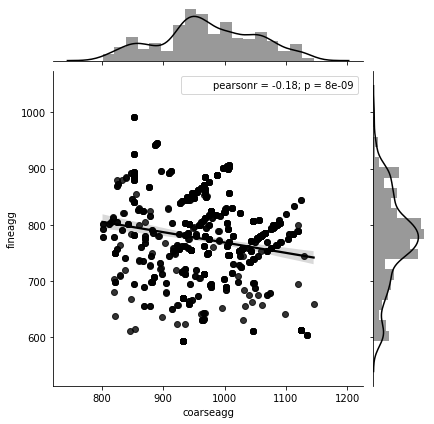

In [694]:
sns.jointplot(concrete.coarseagg, concrete.fineagg, kind='reg', color="k").annotate(stats.pearsonr)

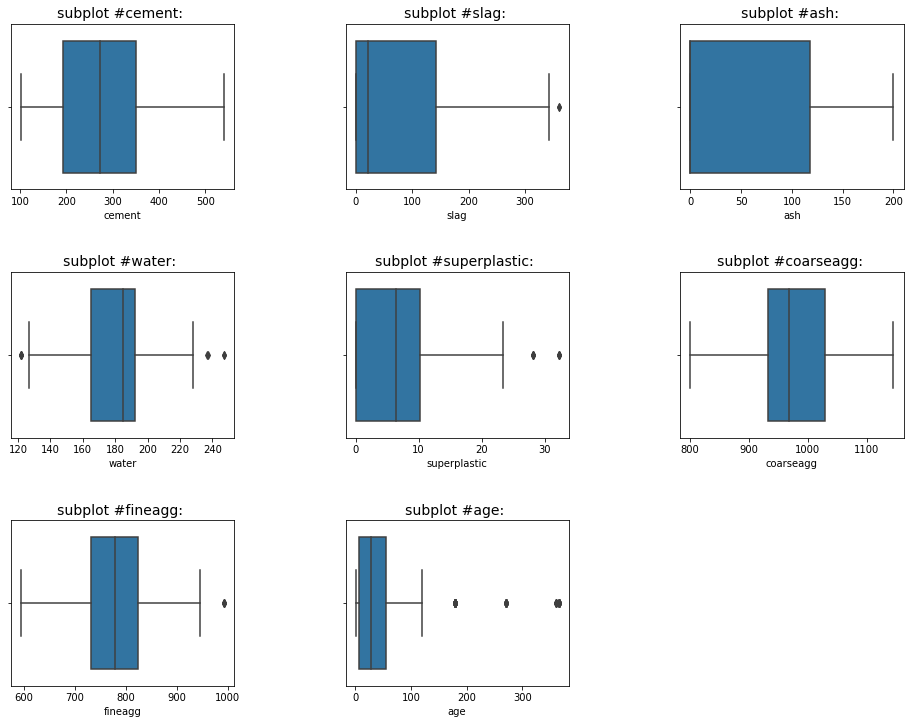

In [695]:
fig = plt.figure(figsize=(16,35))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
#fig.tight_layout(h_pad=100.0, w_pad=100.0)
for i, cols in enumerate(concrete.columns):
    if cols != 'strength':
        fig.add_subplot(8,3,i+1)
        plt.title('subplot #{}: '.format(cols), fontsize=14)
        sns.boxplot(concrete[cols])

In [696]:
IQR = concrete.quantile(0.75) - concrete.quantile(0.25)
#print(IQR)
## lo_limit = concrete.quantile(0.25) - (IQR*1.5)
up_limit = concrete.quantile(0.75) + (IQR*1.5)
print(lo_limit)
print(up_limit)

cement          -44.0625
slag           -214.4250
ash            -177.4500
water           124.2500
superplastic    -15.3000
coarseagg       785.9000
fineagg         591.3750
age             -66.5000
strength         -9.9275
dtype: float64
cement           586.4375
slag             357.3750
ash              295.7500
water            232.6500
superplastic      25.5000
coarseagg       1175.5000
fineagg          963.5750
age              129.5000
strength          79.7725
dtype: float64


## outlier handling ##
1. there is no null or na values.
2. Other than age, the outliers for other columns are reasonably acceptable. 

Drop all rows with age which is more than uplimit for age. Plan to use IQR to handle the outliers

In [697]:
concrete= concrete[(concrete.age < up_limit.age)]
##print("The following are dropped \n\n\n", concrete[(concrete.age < up_limit.age)])

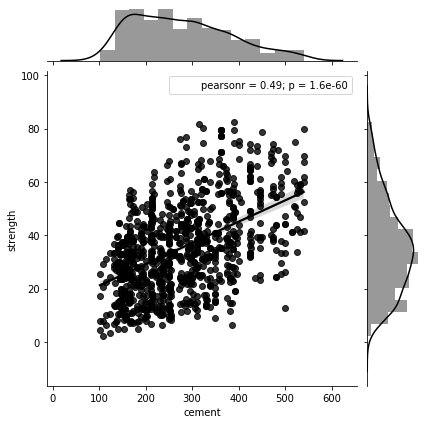

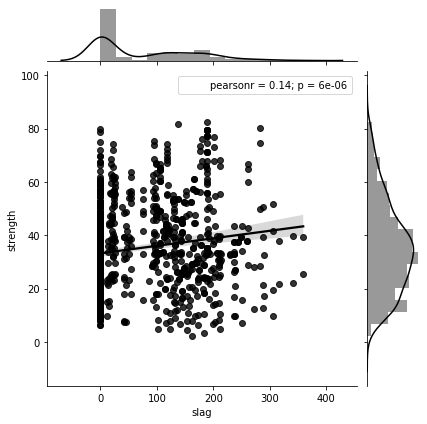

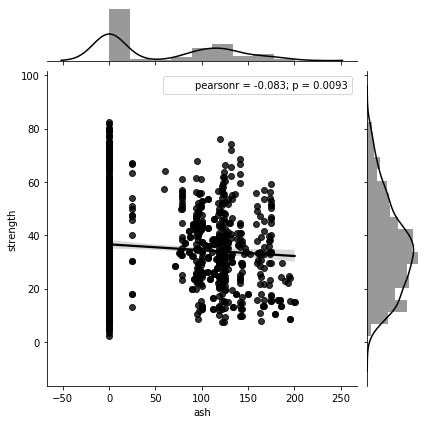

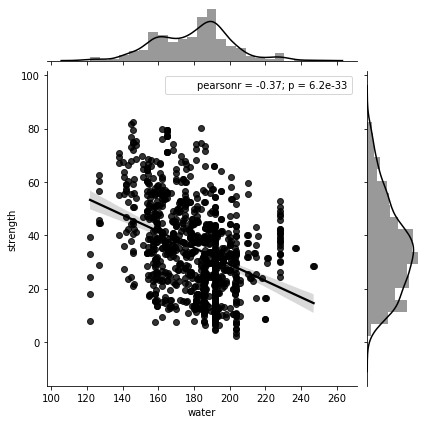

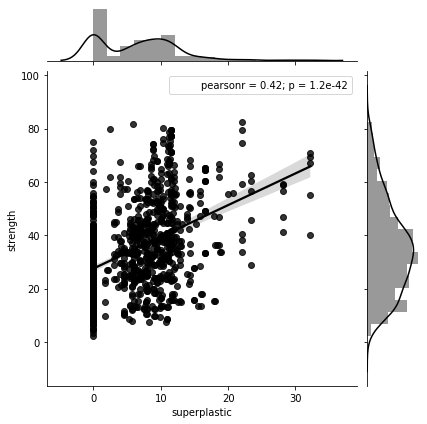

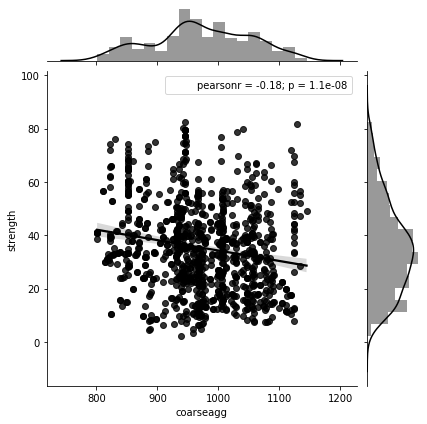

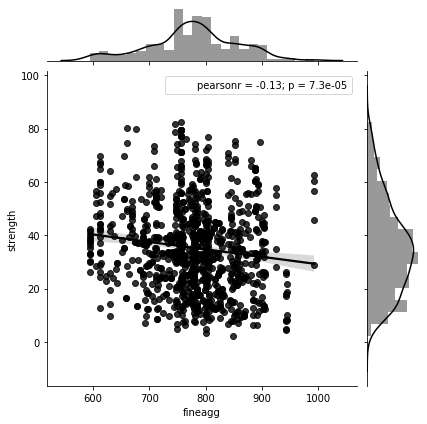

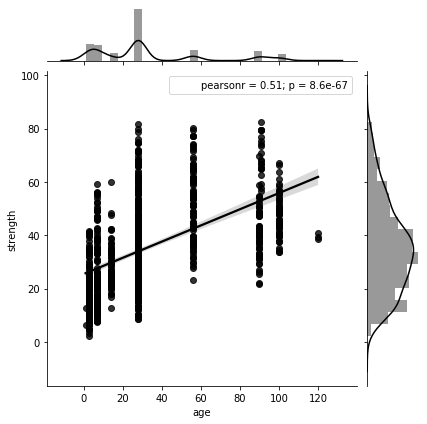

In [698]:
for col in concrete.columns:
    if col != 'strength':
        sns.jointplot(concrete[col], concrete.strength, kind='reg', color="k").annotate(stats.pearsonr)

less water could potentially get better strength

Super plasticity could also potentially get better strenth.

Age also has better potential for better strength.


Things that have limited of impact.
1. fine agg
2. Course Agg
3. slag.

No impact due to Ash.

### Composite Features ###
We can consider three composite FRs
1. cement to fineagg
2. cement to courseagg
3. fine agg to courseagg ratio
4. slag to ash ratio.


should consider adding composite FRs "fine agg to courseagg" and "slag to ash" ratio. Remove these 4 components. These are the weakest components/FRs

however some datapoints have 0 slag or 0 ash. Cant use them as composite FRs. Need to dot these 2.

In [699]:
temp = concrete.fineagg/concrete.coarseagg
concrete["fine2c"] = temp
print(concrete.fine2c)

0       0.770220
1       0.736677
2       0.899990
3       0.718884
4       0.665171
          ...   
1024    0.736703
1025    0.837669
1026    1.048821
1027    0.883002
1029    0.544889
Name: fine2c, Length: 971, dtype: float64


In [700]:
concrete.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cement,971.0,278.077240,104.056297,102.000000,190.300000,261.000000,350.000000,540.000000
slag,971.0,74.776107,86.747745,0.000000,0.000000,22.000000,145.000000,359.400000
ash,971.0,57.480947,64.461419,0.000000,0.000000,0.000000,118.300000,200.100000
water,971.0,179.791246,20.214404,121.800000,164.800000,182.500000,192.000000,247.000000
superplastic,971.0,6.581668,5.947564,0.000000,0.000000,7.000000,10.400000,32.200000
coarseagg,971.0,972.969825,78.711731,801.000000,931.250000,968.000000,1030.500000,1145.000000
fineagg,971.0,777.690113,76.738162,594.000000,740.150000,780.100000,825.000000,992.600000
age,971.0,32.514933,28.616384,1.000000,7.000000,28.000000,28.000000,120.000000
strength,971.0,35.310999,16.877191,2.330000,22.940000,33.610000,45.535000,82.600000
fine2c,971.0,0.805920,0.114050,0.533369,0.736703,0.794318,0.895883,1.164887


In [701]:
concrete_z = concrete.apply(stats.zscore)

In [702]:
concrete_z.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cement,971.0,-5.854111e-17,1.000515,-1.693006,-0.843990,-0.164200,0.691547,2.518423
slag,971.0,-1.954038e-16,1.000515,-0.862439,-0.862439,-0.608699,0.809936,3.282743
ash,971.0,-2.661791e-16,1.000515,-0.892170,-0.892170,-0.892170,0.943982,2.213612
water,971.0,1.109365e-15,1.000515,-2.870286,-0.741994,0.134070,0.604274,3.326509
superplastic,971.0,3.121430e-16,1.000515,-1.107186,-1.107186,0.070373,0.642330,4.309585
coarseagg,971.0,-1.715072e-17,1.000515,-2.185931,-0.530306,-0.063172,0.731274,2.186699
fineagg,971.0,1.815689e-16,1.000515,-2.394959,-0.489450,0.031420,0.616828,2.802004
age,971.0,-3.304371e-17,1.000515,-1.101857,-0.892079,-0.157856,-0.157856,3.058742
strength,971.0,1.525270e-16,1.000515,-1.955183,-0.733379,-0.100839,0.606100,2.803391
fine2c,971.0,5.460788e-16,1.000515,-2.390980,-0.607211,-0.101778,0.789208,3.149065


The score is 0.8385329452395766


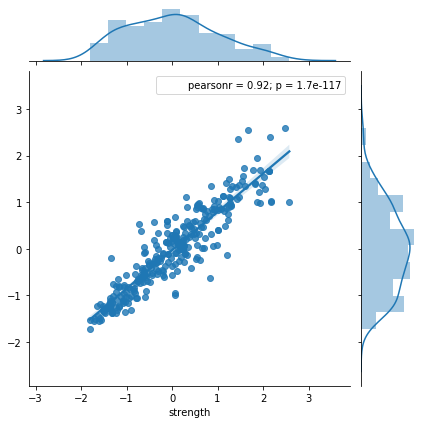

In [703]:
## split data ##
X_train, X_test, y_train, y_test = train_test_split(concrete_z.drop(["strength","fine2c"],axis=1), concrete_z.strength, test_size = 0.3, random_state=93)
clr = SVR()
clr.fit(X_train, y_train)
y_pred = clr.predict(X_test)
sns.jointplot(x=y_test, y=y_pred, kind='reg').annotate(stats.pearsonr)
print("The score is", clr.score(X_test,y_test))

In [704]:
#concrete_z = concrete_z.drop(["ash","slag"], axis=1)
#concrete = concrete["slag"].drop

## Prediction after drop of ash and slag## 

In [705]:
## split data ##å
X_train, X_test, y_train, y_test = train_test_split(concrete_z.drop(["strength","ash","slag","fine2c"],axis=1), concrete_z.strength, test_size = 0.4, random_state=93)

The score is 0.78701915771629


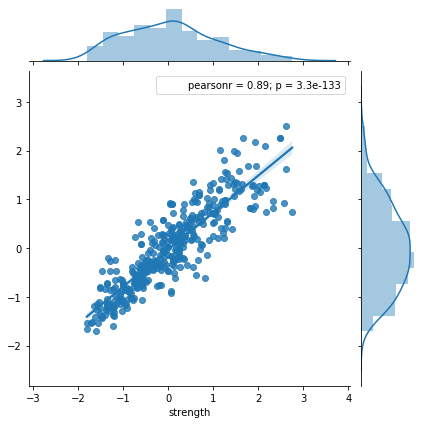

In [706]:
clr = SVR()
clr.fit(X_train, y_train)
y_pred = clr.predict(X_test)
sns.jointplot(x=y_test, y=y_pred, kind='reg').annotate(stats.pearsonr)
print("The score is", clr.score(X_test,y_test))

Ash and slag seems to reduce the prediciton by 5%


## Prediction after drop of fine and coarse agg and fine2c## 

The score is 0.8392218753586731


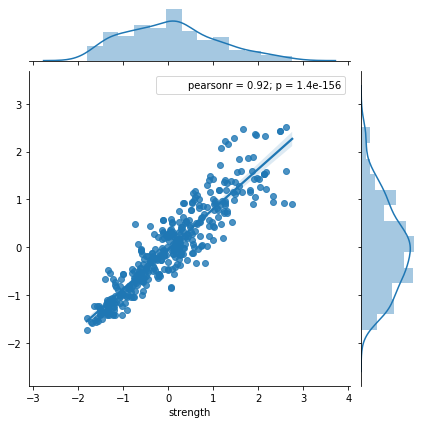

In [707]:
## split data ##å
X_train, X_test, y_train, y_test = train_test_split(concrete_z.drop(["strength","fineagg","coarseagg","fine2c"],axis=1), concrete_z.strength, test_size = 0.4, random_state=93)
clr = SVR()
clr.fit(X_train, y_train)
y_pred = clr.predict(X_test)
sns.jointplot(x=y_test, y=y_pred, kind='reg').annotate(stats.pearsonr)
print("The score is", clr.score(X_test,y_test))

Removing aggregate features seems to have no impact on the calculation. Possible to remove?

## Remove fineagg and coasrse agg, keep fine2c ##

The score is 0.8441977150346138


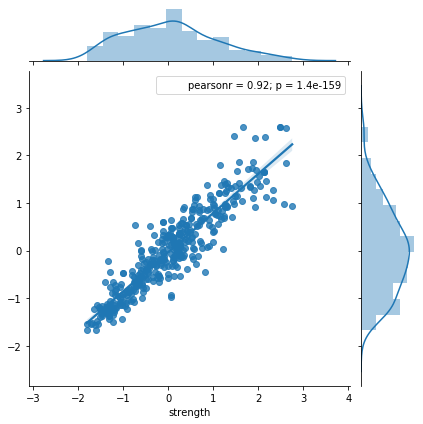

In [708]:
## split data ##å
X_train, X_test, y_train, y_test = train_test_split(concrete_z.drop(["strength","fineagg","coarseagg"],axis=1), concrete_z.strength, test_size = 0.4, random_state=93)
clr = SVR()
clr.fit(X_train, y_train)
y_pred = clr.predict(X_test)
sns.jointplot(x=y_test, y=y_pred, kind='reg').annotate(stats.pearsonr)
print("The score is", clr.score(X_test,y_test))

0.8392218753586731


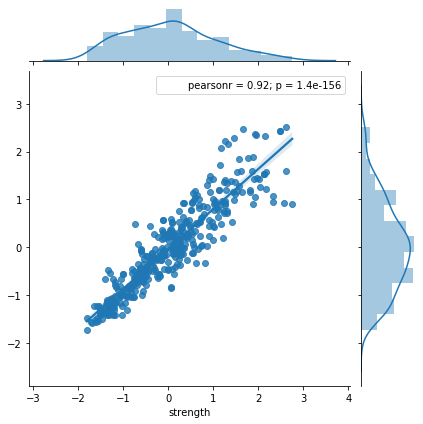

In [709]:
## split data ##å
X_train, X_test, y_train, y_test = train_test_split(concrete_z.drop(["strength","fineagg","coarseagg","fine2c"],axis=1), concrete_z.strength, test_size = 0.4, random_state=93)
clr = SVR()
clr.fit(X_train, y_train)
y_pred = clr.predict(X_test)
sns.jointplot(x=y_test, y=y_pred, kind='reg').annotate(stats.pearsonr)
print(clr.score(X_test, y_test))

## Observations ## 
Can definitely drop fineagg and coarseagg. The composite feature adds negligble value.

In [710]:
concrete_z = concrete_z.drop(["fineagg","coarseagg","fine2c"],axis=1)

# Linear Regression #

In [711]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(concrete_z.drop(["strength"],axis=1), concrete_z.strength, test_size=30, random_state = 93)

The score is 0.735695322291539


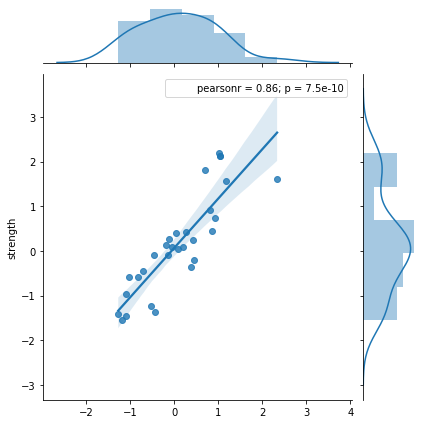

In [712]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)
sns.jointplot(y_pred, y_test,kind="reg").annotate(stats.pearsonr)
print("The score is", lr.score(X_test,y_test))

In [713]:
print(lr.coef_)

[ 0.67565012  0.4415731   0.24413282 -0.22576034  0.05438334  0.52929216]


In [714]:
#print(concrete_z.columns)
#print(lr.coef_[0][2])
for i, col_name in enumerate(X_train.columns):
    print("Coeficient for ", col_name, " is: ",lr.coef_[i])

Coeficient for  cement  is:  0.6756501232617105
Coeficient for  slag  is:  0.4415730974229312
Coeficient for  ash  is:  0.24413282144158566
Coeficient for  water  is:  -0.22576034178098894
Coeficient for  superplastic  is:  0.054383338907668145
Coeficient for  age  is:  0.5292921606344472


In [715]:
from sklearn.preprocessing import PolynomialFeatures 
poly = PolynomialFeatures(degree=2, interaction_only=True)

In [716]:
X_poly  = poly.fit_transform(concrete_z.drop(["strength"], axis=1))
###print(X_poly)
X_train, X_test, y_train, y_test = train_test_split(X_poly, concrete_z.strength, test_size=0.3, random_state=93)
X_train.shape

(679, 22)

The score for 2nd degree polynoimial is 0.7427534438477541


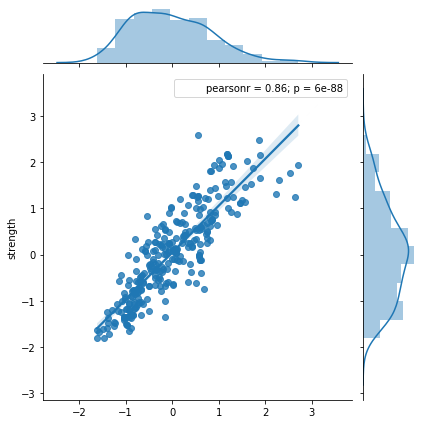

In [717]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)
sns.jointplot(y_pred, y_test,kind="reg").annotate(stats.pearsonr)
print("The score for 2nd degree polynoimial is", lr.score(X_test,y_test))


The score for 3rd degree polynoimial is 0.7466084776631094


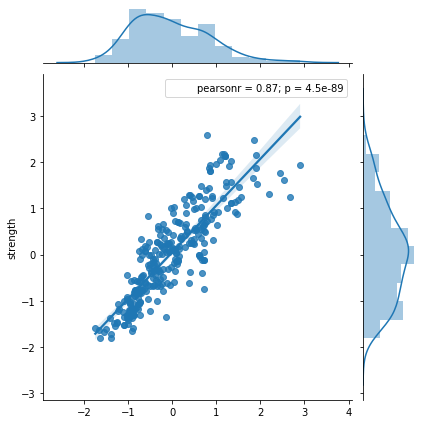

In [718]:

poly = PolynomialFeatures(degree=3, interaction_only=True)
X_poly  = poly.fit_transform(concrete_z.drop(["strength"], axis=1))
X_train, X_test, y_train, y_test = train_test_split(X_poly, concrete_z.strength, test_size=0.3, random_state=93)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)
sns.jointplot(y_pred, y_test,kind="reg").annotate(stats.pearsonr)
print("The score for 3rd degree polynoimial is", lr.score(X_test,y_test))

The score for 4th degree polynoimial is 0.746826825602316


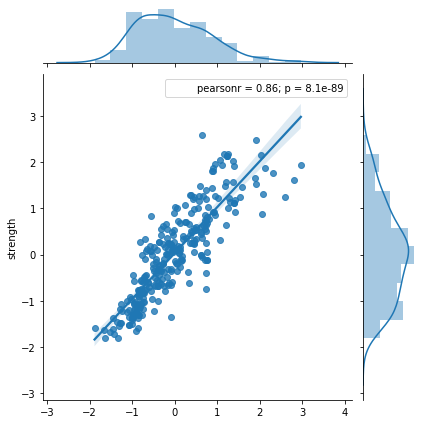

In [719]:

poly = PolynomialFeatures(degree=4, interaction_only=True)
X_poly  = poly.fit_transform(concrete_z.drop(["strength"], axis=1))
X_train, X_test, y_train, y_test = train_test_split(X_poly, concrete_z.strength, test_size=0.3, random_state=93)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)
sns.jointplot(y_pred, y_test,kind="reg").annotate(stats.pearsonr)
print("The score for 4th degree polynoimial is", lr.score(X_test,y_test))

### Observation - Poly vs linear ###
Polynomial give 2% better score than Linear. However2nd, 3rd, 4th degree dont have a big difference. 
Linear can be considered for simplicity fo the model.

# Feature importance and number of clusers #
Plan to use KMeans to find feature importance.

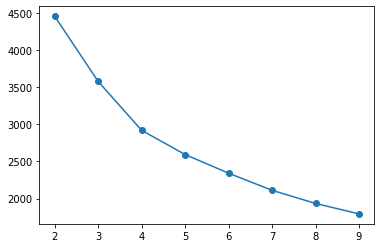

In [720]:
cluster_range = range( 2, 10 )
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5)
  clusters.fit(concrete_z.drop(["strength"],axis=1))
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

4 seems to be the best choice of cluster

In [721]:
clusters = KMeans( 5, n_init = 5)
clusters.fit(concrete_z.drop(["strength"],axis=1))
labels = clusters.labels_
centroids = clusters.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(concrete_z.drop(["strength"],axis=1)) )
centroid_df

,cement,slag,ash,water,superplastic,age
0,-0.543998,-0.302204,1.080710,-0.096269,0.373725,-0.388039
1,-0.682034,1.315361,-0.837355,0.679704,-0.651612,-0.120217
2,-0.463791,-0.680297,0.947508,-0.549348,0.230266,1.648001
3,1.098930,0.447185,-0.593200,-1.088952,1.254723,0.027600
4,0.827382,-0.813421,-0.813510,0.621574,-1.029118,-0.156668


In [722]:
prediction=clusters.predict(concrete_z.drop(["strength"],axis=1))
concrete_z["GROUP"]= prediction

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7febeeb3c350>,
      dtype=object)

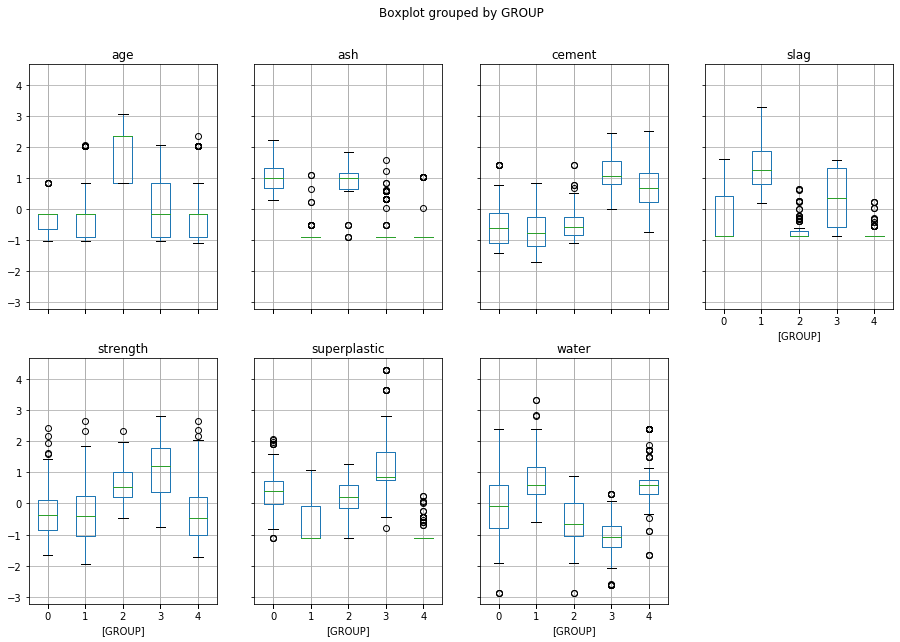

In [723]:
concrete_z.boxplot(by = 'GROUP',  layout=(2,4), figsize=(15, 10))

## Observations #
When choosing 4 clusters, Strength is highest with group 4.  Strength seems a factor of
1. larger age
2. More cement
3. More super plastic
4. and less water.


When choosing 5 clusters, there is higher chance of gettign stronger concrete in group 5. however group 4 can product similar results most of the times. 
- we can see we can achieve approximately similar strength in less time (lower age) when we add ash. This seems to be a shortcut

These 4 independent variables are most suitable for predicting higher strength

# finding feature importance #

In [724]:
from sklearn.tree import DecisionTreeRegressor
concrete_z = concrete_z.drop(["GROUP"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(concrete_z.drop(["strength"],axis=1), concrete_z.strength, test_size=30, random_state = 93)
dtr = DecisionTreeRegressor(random_state=0, max_depth=5)
dtr.fit(X_train,y_train)
feat_imp = dtr.feature_importances_
print(feat_imp)
print(X_train.columns)

[0.41039981 0.09123711 0.00425346 0.1181641  0.02586628 0.35007923]
Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'age'], dtype='object')


## Most important Features ##
1. Cement
2. Age
3. Water
4. Slag with 9% importance - This is wierd. Cluster showed Super plastic seemed better prdecitor.
5. Super Plastic


# Algorithms that could help #
1. Linear-regression - is the simplest. I suspect this is not the most suitable. However, this would be my baseline. We have already tried above to compare with polynomial FRs. Gave a good score. Maybe it will improve with hyperparameter tuning
1. Linear-regression with Poly
2. lasso Regression with normal features
2. Lasso Regression + poly - This would reduce the number of Feartures to be modelled. Could be simpler and sharper model.
2. KNN - Wewere able to see some obvious clusters for the higher strength. They primarily pointed to a combination of water,, cement, age. this means we should be able to see neighbors and predict accordngly.
3. SVR - Have already tried for Feature selection. It gave a good score of 90%. More importantly. It should be able to create hyperplanes by projecting this into additional dimentions.
4. RandomForest - With voting. 


In [725]:
X_train, X_test, y_train, y_test = train_test_split(concrete_z.drop(["strength"],axis=1), concrete_z.strength, test_size=0.4, random_state = 93)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = 93)

In [726]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


##pipe_lr = make_pipeline(LassoCV(), LinearRegression())

pipe_lr_poly = make_pipeline(PolynomialFeatures(), LinearRegression())
pipe_lr_pca = make_pipeline(PCA(), LinearRegression())
pipe_lr = make_pipeline(LinearRegression())

pipe_lasso_poly = make_pipeline(PolynomialFeatures(), LassoCV())
pipe_lasso = make_pipeline(LassoCV())
pipe_svr = make_pipeline(PCA(),SVR())
pipe_knn = make_pipeline(PCA(),KNeighborsRegressor())
pipe_RF = make_pipeline(PCA(),RandomForestRegressor())
#KNeighborsRegressor
#RandomForestRegressor
#PCA()
##PolynomialFeatures()
##LassoC



In [727]:
params_lasso = {}#'lassocv__fit__alpha':[0.005, 0.02, 0.03, 0.05, 0.06]}
params_lasso_poly = {'polynomialfeatures__degree':[1,2,3,4]}#, 'lassocv__fit__alpha':[0.005, 0.02, 0.03, 0.05, 0.06]}
params_lr_pca = {'pca__n_components':[2,3,4,5,6]}
params_lr_poly = {'polynomialfeatures__degree':[1,2,3,4]}
params_lr = {}
params_svr = {'pca__n_components':[3,4,5,6],'svr__C':[1,10,100,1000],'svr__kernel':['rbf','linear']}
params_knn = {'pca__n_components':[3,4,5,6],'kneighborsregressor__n_neighbors':[3,4,5,6,7]}
params_RF = {'pca__n_components':[3,4,5,6],'randomforestregressor__max_depth':[3,4,5], 'randomforestregressor__n_estimators':[90,100,120,150], }

##params_svr = {'pca__n_component':[3,4,5,6],'svr__C':[1,10,100,1000],'svr__kernel':['rbf','linear']}
import warnings
warnings.filterwarnings('ignore')
score = pd.DataFrame(columns=["LinearRegression","LinearRegression with PCA","LinearRegression with PolynomialFeatures","LassoCV","LassoCV with PolynomialFeatures","SVR","KNN", "RF"])
Accuracy = pd.DataFrame(columns=["LinearRegression","LinearRegression with PCA","LinearRegression with PolynomialFeatures","LassoCV","LassoCV with PolynomialFeatures","SVR","KNN", "RF"])
SD = pd.DataFrame(columns=["LinearRegression","LinearRegression with PCA","LinearRegression with PolynomialFeatures","LassoCV","LassoCV with PolynomialFeatures","SVR","KNN", "RF"])
score.loc["0"] = [0,0,0,0,0,0,0,0]
Accuracy.loc["0"] = [0,0,0,0,0,0,0,0]
SD.loc["0"] = [0,0,0,0,0,0,0,0]

kfold = KFold(n_splits=10, random_state=7)

{}


 Linear model gives a score of  0.7162926910284637


[0.56385346 0.73301897 0.7558892  0.87052055 0.53725278 0.72838445
 0.70612808 0.66464527 0.53847606 0.64559021]
Accuracy: 67.438% (10.144%)


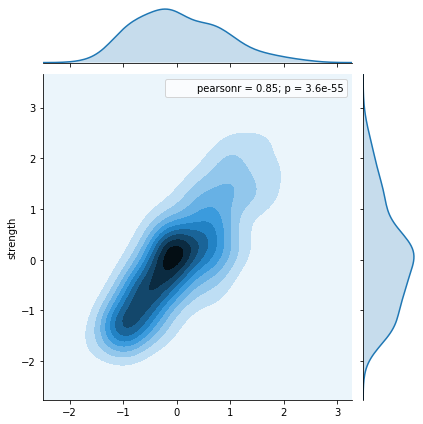

In [728]:
### Simple Linear Regression + No Preprocessing ###
search_lr = RandomizedSearchCV(pipe_lr,param_distributions=params_lr)
search_lr.fit(X_train,y_train)
print(search_lr.best_params_)
model_lr = search_lr.best_estimator_
model_lr.fit(X_val,y_val)
y_pred=model_lr.predict(X_test)
print("\n\n Linear model gives a score of ", model_lr.score(X_test,y_test))
print()
print()
sns.jointplot(y_pred,y_test,kind='kde').annotate(stats.pearsonr)
results = cross_val_score(model_lr, X_test, y_test, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
score["LinearRegression"]=model_lr.score(X_test,y_test)
Accuracy["LinearRegression"]=results.mean()*100.0
SD["LinearRegression"]=results.std()*100.0


{'pca__n_components': 6}


 Linear train model gives a score of  0.7719097621438374
Linear val model gives a score of  0.7254015615839557
Linear test model gives a score of  0.7162926910284639


[0.56385346 0.73301897 0.7558892  0.87052055 0.53725278 0.72838445
 0.70612808 0.66464527 0.53847606 0.64559021]
Accuracy: 67.438% (10.144%)


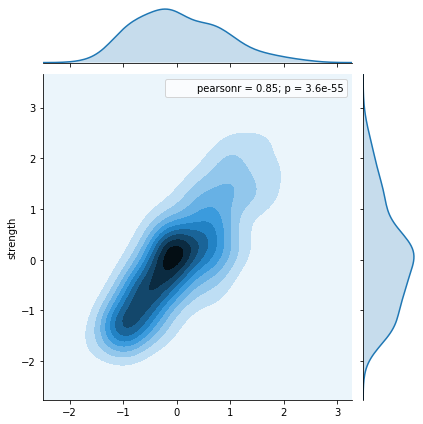

In [729]:
### Simpler Linear Regression + PCA ###
search_lr_pca = RandomizedSearchCV(pipe_lr_pca,param_distributions=params_lr_pca)
search_lr_pca.fit(X_train,y_train)
print(search_lr_pca.best_params_)
model_lr_pca = search_lr_pca.best_estimator_
model_lr_pca.fit(X_val,y_val)
y_pred=model_lr_pca.predict(X_test)
print("\n\n Linear train model gives a score of ", model_lr_pca.score(X_train,y_train))
print("Linear val model gives a score of ", model_lr_pca.score(X_val,y_val))
print("Linear test model gives a score of ", model_lr_pca.score(X_test,y_test))
print()
print()
sns.jointplot(y_pred,y_test,kind='kde').annotate(stats.pearsonr)
score["LinearRegression with PCA"]=model_lr_pca.score(X_test,y_test)
results = cross_val_score(model_lr_pca, X_test, y_test, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
score["LinearRegression with PCA"]=model_lr_pca.score(X_test,y_test)
Accuracy["LinearRegression with PCA"]=results.mean()*100.0
SD["LinearRegression with PCA"]=results.std()*100.0

{'polynomialfeatures__degree': 3}


 Linear Train model gives a score of  0.5408942092781837
Linear Val model gives a score of  0.924011501510385
Linear Test model gives a score of  0.41688772855733836


[0.69031434 0.63857061 0.87930923 0.67167214 0.59206025 0.69206044
 0.86591033 0.19690189 0.37348976 0.22438715]
Accuracy: 58.247% (22.888%)


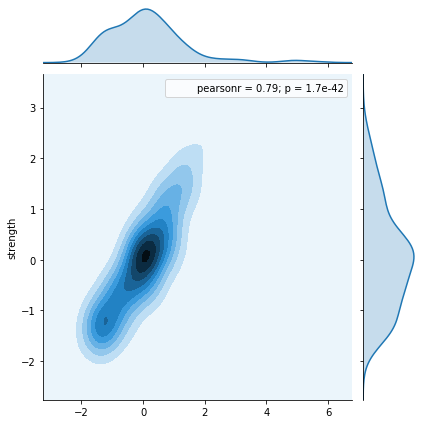

In [730]:
### Simpler Linear Regression + Polynomial ###
search_lr_poly = RandomizedSearchCV(pipe_lr_poly,param_distributions=params_lr_poly)
search_lr_poly.fit(X_train,y_train)
print(search_lr_poly.best_params_)
model_lr_poly = search_lr_poly.best_estimator_
model_lr_poly.fit(X_val,y_val)
y_pred=model_lr_poly.predict(X_test)
print("\n\n Linear Train model gives a score of ", model_lr_poly.score(X_train,y_train))
print("Linear Val model gives a score of ", model_lr_poly.score(X_val,y_val))
print("Linear Test model gives a score of ", model_lr_poly.score(X_test,y_test))
print()
print()
sns.jointplot(y_pred,y_test,kind='kde').annotate(stats.pearsonr)
score["LinearRegression with PolynomialFeatures"]=model_lr_poly.score(X_test,y_test)
results = cross_val_score(model_lr_poly, X_test, y_test, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
score["LinearRegression with PolynomialFeatures"]=model_lr_poly.score(X_test,y_test)
Accuracy["LinearRegression with PolynomialFeatures"]=results.mean()*100.0
SD["LinearRegression with PolynomialFeatures"]=results.std()*100.0

{}


Lasso Regression Train model gives a score of  0.7714071904186589
Lasso Regression Val model gives a score of  0.7252319303266339
Lasso Regression Test model gives a score of  0.7154534822983503


[0.56440399 0.73294899 0.75533804 0.86984515 0.53783725 0.72789828
 0.70598559 0.66469318 0.54297783 0.64618918]
Accuracy: 67.481% (10.047%)


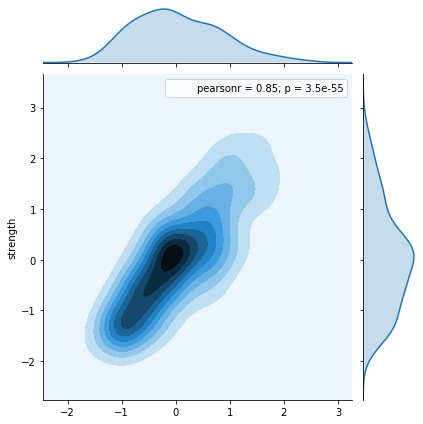

In [731]:
### Simple LassoCV ###
search_lasso = RandomizedSearchCV(pipe_lasso,param_distributions=params_lasso)
search_lasso.fit(X_train,y_train)
print(search_lasso.best_params_)
model_lasso = search_lasso.best_estimator_
model_lasso.fit(X_val,y_val)
y_pred=model_lasso.predict(X_test)
print("\n\nLasso Regression Train model gives a score of ", model_lasso.score(X_train,y_train))
print("Lasso Regression Val model gives a score of ", model_lasso.score(X_val,y_val))
print("Lasso Regression Test model gives a score of ", model_lasso.score(X_test,y_test))
print()
print()
sns.jointplot(y_pred,y_test,kind='kde').annotate(stats.pearsonr)
score["LassoCV"]=model_lasso.score(X_test,y_test)
results = cross_val_score(model_lasso, X_test, y_test, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
score["LassoCV"]=model_lasso.score(X_test,y_test)
Accuracy["LassoCV"]=results.mean()*100.0
SD["LassoCV"]=results.std()*100.0

{'polynomialfeatures__degree': 3}


Lasso Regression with p[olynomials train model gives a score of  0.8090656867477815
Lasso Regression with p[olynomials val model gives a score of  0.8812550871584288
Lasso Regression with p[olynomials test model gives a score of  0.7592737537420239


[0.71989754 0.78691462 0.8886061  0.9023545  0.62394418 0.83111374
 0.81465886 0.81146352 0.76904672 0.65019728]
Accuracy: 77.982% (8.749%)


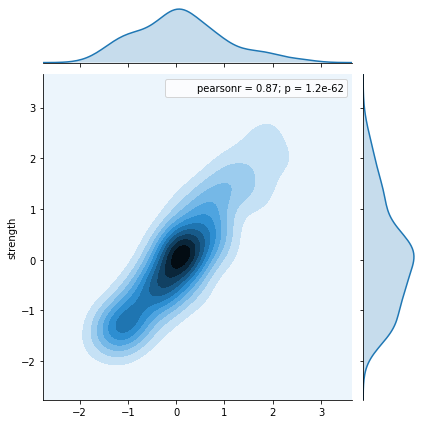

In [732]:
### Simple LassoCV with Polyniomial Features ###
search_lasso_poly = RandomizedSearchCV(pipe_lasso_poly,param_distributions=params_lasso_poly)
search_lasso_poly.fit(X_train,y_train)
print(search_lasso_poly.best_params_)
model_lasso_poly = search_lasso_poly.best_estimator_
model_lasso_poly.fit(X_val,y_val)
y_pred=model_lasso_poly.predict(X_test)
print("\n\nLasso Regression with p[olynomials train model gives a score of ", model_lasso_poly.score(X_train,y_train))
print("Lasso Regression with p[olynomials val model gives a score of ", model_lasso_poly.score(X_val,y_val))
print("Lasso Regression with p[olynomials test model gives a score of ", model_lasso_poly.score(X_test,y_test))
print()
print()
sns.jointplot(y_pred,y_test,kind='kde').annotate(stats.pearsonr)
score["LassoCV with PolynomialFeatures"]=model_lasso_poly.score(X_test,y_test)
results = cross_val_score(model_lasso_poly, X_test, y_test, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
score["LassoCV with PolynomialFeatures"]=model_lasso_poly.score(X_test,y_test)
Accuracy["LassoCV with PolynomialFeatures"]=results.mean()*100.0
SD["LassoCV with PolynomialFeatures"]=results.std()*100.0

{'svr__kernel': 'rbf', 'svr__C': 1, 'pca__n_components': 6}



Support Vector Regressor train model gives a score of  0.8285335614489154
Support Vector Regressor val model gives a score of  0.8599939076470351
Support Vector Regressor test model gives a score of  0.8155267068632089


[0.71694279 0.83491509 0.87204442 0.87067091 0.62999895 0.83130985
 0.84535117 0.81835899 0.7935902  0.81386577]
Accuracy: 80.270% (7.123%)


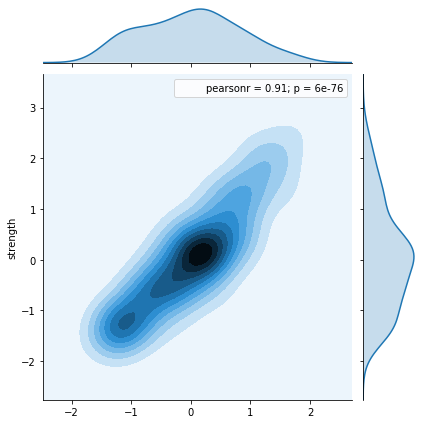

In [733]:
search_svr = RandomizedSearchCV(pipe_svr,param_distributions=params_svr)
search_svr.fit(X_train,y_train)
print(search_svr.best_params_)
model_svr = search_svr.best_estimator_
model_svr.fit(X_val,y_val)
y_pred=model_svr.predict(X_test)
print("\n\n\nSupport Vector Regressor train model gives a score of ", model_svr.score(X_train,y_train))
print("Support Vector Regressor val model gives a score of ", model_svr.score(X_val,y_val))
print("Support Vector Regressor test model gives a score of ", model_svr.score(X_test,y_test))
print()
print()
sns.jointplot(y_pred,y_test,kind='kde').annotate(stats.pearsonr)
score["SVR"]=model_svr.score(X_test,y_test)
results = cross_val_score(model_svr, X_test, y_test, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
score["SVR"]=model_svr.score(X_test,y_test)
Accuracy["SVR"]=results.mean()*100.0
SD["SVR"]=results.std()*100.0

{'randomforestregressor__n_estimators': 120, 'randomforestregressor__max_depth': 5, 'pca__n_components': 5}



Random Forest Regresssor , on the train, gives a score of  0.7509333946775839
Random Forest Regresssor , on the val, gives a score of  0.8941164114304535
Random Forest Regresssor , on the test, gives a score of  0.7494305390972951


[0.44381908 0.86479901 0.81865978 0.78534698 0.45723609 0.81935372
 0.69447803 0.83931076 0.74603944 0.63819913]
Accuracy: 71.072% (14.545%)


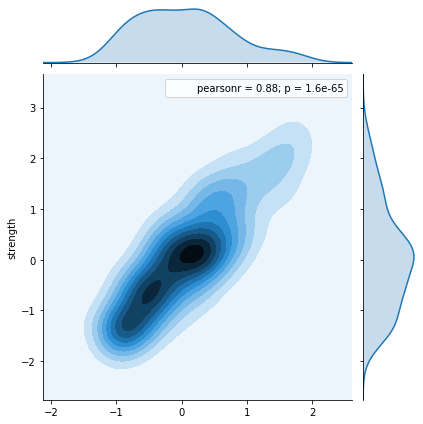

In [734]:
search_RF = RandomizedSearchCV(pipe_RF,param_distributions=params_RF)
search_RF.fit(X_train,y_train)
print(search_RF.best_params_)
model_rf = search_RF.best_estimator_
model_rf.fit(X_val,y_val)
y_pred=model_rf.predict(X_test)
print("\n\n\nRandom Forest Regresssor , on the train, gives a score of ", model_rf.score(X_train,y_train))
print("Random Forest Regresssor , on the val, gives a score of ", model_rf.score(X_val,y_val))
print("Random Forest Regresssor , on the test, gives a score of ", model_rf.score(X_test,y_test))
print()
print()
sns.jointplot(y_pred,y_test,kind='kde').annotate(stats.pearsonr)
score["RF"]=model_rf.score(X_test,y_test)
results = cross_val_score(model_rf, X_test, y_test, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
score["RF"]=model_rf.score(X_test,y_test)
Accuracy["RF"]=results.mean()*100.0
SD["RF"]=results.std()*100.0

{'pca__n_components': 6, 'kneighborsregressor__n_neighbors': 4}



K Nearest Neighbor Regresssor , on the train, gives a score of  0.7359029526704584
K Nearest Neighbor Regresssor , on the val, gives a score of  0.8228131317979173
K Nearest Neighbor Regresssor , on the test, gives a score of  0.7274834995490422


[0.52525003 0.65963987 0.73312182 0.85628968 0.66848363 0.69369924
 0.53037784 0.82539779 0.70422061 0.68970313]
Accuracy: 68.862% (10.102%)


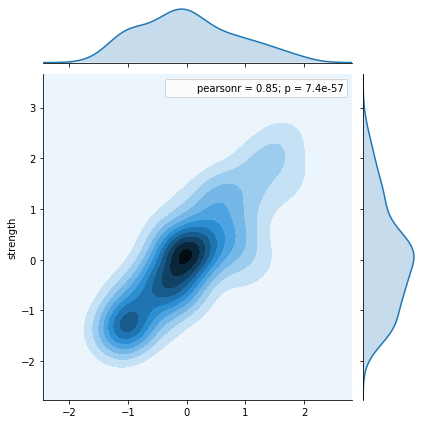

In [735]:
search_knn = RandomizedSearchCV(pipe_knn,param_distributions=params_knn)
search_knn.fit(X_train,y_train)

print(search_knn.best_params_)
model_knn = search_knn.best_estimator_
model_knn.fit(X_val,y_val)
y_pred=model_knn.predict(X_test)
print("\n\n\nK Nearest Neighbor Regresssor , on the train, gives a score of ", model_knn.score(X_train,y_train))
print("K Nearest Neighbor Regresssor , on the val, gives a score of ", model_knn.score(X_val,y_val))
print("K Nearest Neighbor Regresssor , on the test, gives a score of ", model_knn.score(X_test,y_test))
print()
print()
sns.jointplot(y_pred,y_test,kind='kde').annotate(stats.pearsonr)
score["KNN"]=model_knn.score(X_test,y_test)
results = cross_val_score(model_knn, X_test, y_test, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
score["KNN"]=model_knn.score(X_test,y_test)
Accuracy["KNN"]=results.mean()*100.0
SD["KNN"]=results.std()*100.0

In [736]:
score = score*100
score.transpose()

,0
LinearRegression,71.629269
LinearRegression with PCA,71.629269
LinearRegression with PolynomialFeatures,41.688773
LassoCV,71.545348
LassoCV with PolynomialFeatures,75.927375
SVR,81.552671
KNN,72.748350
RF,74.943054


In [737]:
Accuracy.transpose()

,0
LinearRegression,67.437590
LinearRegression with PCA,67.437590
LinearRegression with PolynomialFeatures,58.246762
LassoCV,67.481175
LassoCV with PolynomialFeatures,77.981970
SVR,80.270481
KNN,68.861836
RF,71.072420


In [738]:
SD.transpose()

,0
LinearRegression,10.143535
LinearRegression with PCA,10.143535
LinearRegression with PolynomialFeatures,22.887715
LassoCV,10.047196
LassoCV with PolynomialFeatures,8.749380
SVR,7.122989
KNN,10.101866
RF,14.545038


In [739]:
LoAT95 = pd.DataFrame(columns=["LinearRegression","LinearRegression with PCA","LinearRegression with PolynomialFeatures","LassoCV","LassoCV with PolynomialFeatures","SVR","KNN", "RF"])
HiAT95 = pd.DataFrame(columns=["LinearRegression","LinearRegression with PCA","LinearRegression with PolynomialFeatures","LassoCV","LassoCV with PolynomialFeatures","SVR","KNN", "RF"])
LoAT95.loc["0"] = [0,0,0,0,0,0,0,0]
HiAT95.loc["0"] = [0,0,0,0,0,0,0,0]

for i in SD.columns:
    print(i)
    LoAT95[i]=Accuracy[i]-(2*SD[i])
    HiAT95[i]=Accuracy[i]+(2*SD[i])

LoAT95.transpose()
#HiAT95.transpose()



LinearRegression
LinearRegression with PCA
LinearRegression with PolynomialFeatures
LassoCV
LassoCV with PolynomialFeatures
SVR
KNN
RF


,0
LinearRegression,47.150520
LinearRegression with PCA,47.150520
LinearRegression with PolynomialFeatures,12.471331
LassoCV,47.386783
LassoCV with PolynomialFeatures,60.483211
SVR,66.024504
KNN,48.658104
RF,41.982344


In [740]:
LoAT95.rename(index={'0': 'LoAT95'}, inplace=True)
HiAT95.rename(index={'0': 'HiAT95'}, inplace=True)
score.rename(index={'0': 'score'}, inplace=True)
Accuracy.rename(index={'0': 'accuracy'}, inplace=True)
SD.rename(index={'0': 'sd'}, inplace=True)
frame = [score, Accuracy, SD, LoAT95, HiAT95]
fin_score = pd.concat(frame)
fin_score.transpose()

,score,accuracy,sd,LoAT95,HiAT95
LinearRegression,71.629269,67.437590,10.143535,47.150520,87.724661
LinearRegression with PCA,71.629269,67.437590,10.143535,47.150520,87.724661
LinearRegression with PolynomialFeatures,41.688773,58.246762,22.887715,12.471331,104.022193
LassoCV,71.545348,67.481175,10.047196,47.386783,87.575566
LassoCV with PolynomialFeatures,75.927375,77.981970,8.749380,60.483211,95.480730
SVR,81.552671,80.270481,7.122989,66.024504,94.516459
KNN,72.748350,68.861836,10.101866,48.658104,89.065569
RF,74.943054,71.072420,14.545038,41.982344,100.162496


# Observations #
I would go for a model which gives me better accuracy with as much low of SD as possible. Larger Standarddeviation  means accuracy wold be across much wider range. 

For example Random forst gives decent accuracy but standard deviation is very large at 13%.

Considering these I would go for either.
1. Lasso with Polynomial Feartures - This removes certain feature. Would probably be the simplest model with lower accuracy. We can expect an accruacy in the range of 60.5% to 95.5% at 95% confidence level. We can expect an average accuracy of 78%
2. SVR with PCA - Seems to be best model. More complicated and more time consuming. Does yield far better accuracy. If accuracy is most important, i will pick this model. We can expect an accuracy in the range of 67.5% to 95% at 95% confidence level. We can expect an average accuracy of 80%